# Setting

In [1]:
import logging
import os
import pdb
import math
import glob
import random
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.preprocessing import LabelEncoder

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision.transforms as T

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.nn.parameter import Parameter

from tqdm import tqdm
import sys

import copy
from scipy import spatial
import csv

from perceiver import crop, patchify, get_patch_coords, ImageDataset, PerceiverBlock, Perceiver, CustomDataset, CombinedModel

In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

# Load Model, DataLoader

In [3]:
root_dir = '/home/Minju/Perceiver/'
model_dir = root_dir + 'shared_layer_model/'
loader_dir = root_dir + 'shared_layer_loader/'

batch_size = 32

In [4]:
input_models = []
valid_loaders = []

### Text Modality:

In [6]:
for i in range(6):
    checkpoint = torch.load(model_dir + f'text_checkpoint_{i+1}_epoch_40.pth.tar')
    input_models.append(checkpoint)
    print(f'Text {i+1}번 체크포인트 불러오기 완료')

    # with open(loader_dir+f'text_val_loader_{i+1}.pkl', 'rb') as f:
    #     loaded_valid_dataset = pickle.load(f)
    # valid_loaders.append(loaded_valid_dataset)
    # print(f"Text val. loader {i}번 불러오기 완료.")

/tmp/ipykernel_2698142/4002617754.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir + f'text_checkpoint_{i+1}_epoch_40.pth.tar')


Text 1번 체크포인트 불러오기 완료
Text 2번 체크포인트 불러오기 완료
Text 3번 체크포인트 불러오기 완료
Text 4번 체크포인트 불러오기 완료
Text 5번 체크포인트 불러오기 완료
Text 6번 체크포인트 불러오기 완료


In [8]:
# for i in range (6):
#     text_model = torch.load(root_dir + f'text_model_{i+1}.pkl')
#     input_models.append(text_model)
#     print(f"Text model {i+1}번 불러오기 완료.")

#     with open(loader_dir+f'text_val_loader_{i+1}.pkl', 'rb') as f:
#         loaded_valid_dataset = pickle.load(f)
#     valid_loaders.append(loaded_valid_dataset)
#     print(f"Text val. loader {i}번 불러오기 완료.")

### Image Modality:

In [9]:
# for i in range(6):
#     img_model = torch.load(root_dir + f'image_model_{i+1}.pkl')
#     input_models.append(img_model)
#     print(f"Image model {i}번 불러오기 완료.")

#     with open(loader_dir+f'image_val_loader_{i+1}.pkl', 'rb') as f:
#         loaded_valid_dataset = pickle.load(f)

#     valid_loader = DataLoader(loaded_valid_dataset, batch_size=batch_size, shuffle=False)
#     valid_loaders.append(valid_loader)
#     print(f"Image val. loader {i}번 불러오기 완료.")

In [10]:
for i in range(6):
    checkpoint = torch.load(model_dir + f'image_checkpoint_{i+1}_epoch_40.pth.tar')
    input_models.append(checkpoint)
    print(f'image {i+1}번 체크포인트 불러오기 완료')
    with open(loader_dir+f'image_val_loader_{i+1}.pkl', 'rb') as f:
        loaded_valid_dataset = pickle.load(f)

    valid_loader = DataLoader(loaded_valid_dataset, batch_size=batch_size, shuffle=False)
    valid_loaders.append(valid_loader)
    print(f"Image val. loader {i}번 불러오기 완료.")

/tmp/ipykernel_2698142/2064796983.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_dir + f'image_checkpoint_{i+1}_epoch_40.pth.tar')


image 1번 체크포인트 불러오기 완료
Image val. loader 0번 불러오기 완료.
image 2번 체크포인트 불러오기 완료
Image val. loader 1번 불러오기 완료.
image 3번 체크포인트 불러오기 완료
Image val. loader 2번 불러오기 완료.
image 4번 체크포인트 불러오기 완료
Image val. loader 3번 불러오기 완료.
image 5번 체크포인트 불러오기 완료
Image val. loader 4번 불러오기 완료.
image 6번 체크포인트 불러오기 완료
Image val. loader 5번 불러오기 완료.


In [7]:
valid_loaders  

In [8]:
# valid_loader 1-12까지 첫번째 배치 shape 확인

for idx, loader in enumerate(valid_loaders):
    print(f"--- Valid Loader {idx + 1} ---")
    
    batch = next(iter(loader))  
    
    # 배치가 리스트 형식일 경우, inputs과 labels 출력
    if isinstance(batch, list):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    elif isinstance(batch, dict):
        # 배치가 딕셔너리 형식일 때, 각 key-value 쌍의 shape 출력
        print({key: value.shape for key, value in batch.items()})
    elif isinstance(batch, tuple):
        # 배치가 튜플 형식일 때, Inputs과 Labels의 shape 출력
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")

--- Valid Loader 1 ---
{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
--- Valid Loader 2 ---
{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
--- Valid Loader 3 ---
{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
--- Valid Loader 4 ---
{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
--- Valid Loader 5 ---
{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
--- Valid Loader 6 ---
{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
--- Valid Loader 7 ---
Inputs shape: torch.Size([32, 196, 770]), Labels shape: torch.Size([32])
--- Valid Loader 8 ---
Inputs shape: torch.Size([32, 196, 770]), Labels shape: torch.Size([32])
--- Valid Loader 9 ---
Inputs shap

In [9]:
# image, text 모델 확인
image_model_path = "/home/youlee/perceiver/perceiver/model/image_model_1.pkl"
text_model_path = "/home/youlee/perceiver/perceiver/model/text_model_1.pkl"

image_model = torch.load(image_model_path)
print("Image Model:")
print(image_model)

text_model = torch.load(text_model_path)
print("\nText Model:")
print(text_model)

Image Model:
Perceiver(
  (input_projection): Linear(in_features=770, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x PerceiverBlock(
      (cross_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (cross_ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (self_attn_layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)

/tmp/ipykernel_1401749/3364340435.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_model = torch.load(image_model_path)
/tmp/ipykernel_1401749/3364340435.py:9: Futu

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Define ModelDiff

In [11]:
num_classes = -1
lr = 0.1
batch_size = 32
val_batch_size = 100
workers = 24
weight_decay = 4e-5
dataset_name = ''
train_path = ''
val_path = ''
cuda = True
seed = 1
epochs = 160
restore_epoch = 0
save_folder = ''
load_folder = ''
one_shot_prune_perc = 0.5
mode = ''
logfile = ''
initial_from_task = ''

In [12]:
DATASETS = [
    'Opinion','Art & Design','Television',
    'Music','Travel','Real Estate',
    'Books','Theater','Health',
    'Sports','Science','Food',
    'Fashion & Style','Movies','Technology',
    'Dance', 'Media', 'Style'
]

In [13]:
epsilon = 0.1
max_iterations = 100

In [14]:
# target_id = 1

# 유사도검색

task_id 책정방식: \
0~5 : text modality \
6~11: image modality

## Approach 1: 특정 input data로 유사도 검증

In [15]:
# DDV 계산: Cosine Distance
def compute_ddv_cos(
    model1, model2,
    inputs1, inputs2,
    is_model1_text=False,
    is_model2_text=False,
    device='cuda'
):
    with torch.no_grad():
        # model1
        if is_model1_text:
            output1 = model1(inputs1)  
        else:
            output1 = model1(inputs1.float())  

        n_pairs = output1.shape[0] // 2
        dists1 = []
        for i in range(n_pairs):
            ya = output1[i].cpu().numpy()  # GPU -> CPU 변환
            yb = output1[i + n_pairs].cpu().numpy()  # GPU -> CPU 변환
            dist = spatial.distance.cosine(ya, yb)
            dists1.append(dist)

        # model2
        if is_model2_text:
            output2 = model2(inputs2)  
        else:
            output2 = model2(inputs2.float())  

        dists2 = []
        for i in range(n_pairs):
            ya = output2[i].cpu().numpy()  # GPU -> CPU 변환
            yb = output2[i + n_pairs].cpu().numpy()  # GPU -> CPU 변환
            dist = spatial.distance.cosine(ya, yb)
            dists2.append(dist)

    return np.array(dists1), np.array(dists2)

In [16]:
# DDV 계산: Euclidean Distance
def compute_ddv_euc(
    model1, model2,
    inputs1, inputs2,
    is_model1_text=False,
    is_model2_text=False,
    device='cuda'
):
    with torch.no_grad():
        # model1
        if is_model1_text:
            output1 = model1(inputs1)        
        else:
            output1 = model1(inputs1.float()) 

        n_pairs = output1.shape[0] // 2
        dists1 = []
        for i in range(n_pairs):
            ya = output1[i].cpu().numpy()  # GPU -> CPU 변환
            yb = output1[i + n_pairs].cpu().numpy()  # GPU -> CPU 변환
            dist = spatial.distance.euclidean(ya, yb)
            dists1.append(dist)

        # model2
        if is_model2_text:
            output2 = model2(inputs2)
        else:
            output2 = model2(inputs2.float())

        dists2 = []
        for i in range(n_pairs):
            ya = output2[i].cpu().numpy()  # GPU -> CPU 변환
            yb = output2[i + n_pairs].cpu().numpy()  # GPU -> CPU 변환
            dist = spatial.distance.euclidean(ya, yb)
            dists2.append(dist)

    return np.array(dists1), np.array(dists2)

In [17]:
##### compute_similarity #####
def compute_sim_cos(ddv1, ddv2):
    return spatial.distance.cosine(ddv1, ddv2)    

### modelDiff 

In [18]:
# ddvcc_list = []
# ddvec_list = []

# for task_id in range(6):
#     if task_id == target_id:
#         continue

#     # batch = next(iter(valid_loaders[target_id]))  
#     # print(batch)
#     # valid_loader = valid_loaders[target_id]  # valid_loader 가져오기
#     # data_iter = iter(valid_loader)  # 반복자 생성
#     # batch = next(data_iter)  # 첫 번째 배치 가져오기
    
#     # print(batch)  
    
#     # # input_ids를 numpy 또는 tensor로 변환
#     # inputs = batch['input_ids'].to(DEVICE)
#     if target_id >= 6:   # Text Modality
#         batch = next(iter(valid_loaders[target_id]))  
#         inputs = batch['input_ids'].to(DEVICE)
        
#     else:               # Image Modality
#         inputs = next(iter(valid_loaders[target_id]))[0]

#     ddv1, ddv2 = compute_ddv_cos(input_models[target_id], input_models[task_id], inputs)
#     ddv_distance = compute_sim_cos(ddv1, ddv2)
#     print('DDV cos-cos [%d => %d] %.5f'%(task_id, target_id, ddv_distance))
#     ddvcc_list.append(ddv_distance)

#     # DDV-EC
#     ddv1, ddv2 = compute_ddv_euc(input_models[target_id], input_models[task_id], inputs)
#     ddv_distance = compute_sim_cos(ddv1, ddv2)
#     print('DDV euc-cos [%d => %d] %.5f'%(task_id, target_id, ddv_distance))
#     ddvec_list.append(ddv_distance)

In [19]:
ddvcc_list_all = []  # (target_id, task_id, cos-distance) 
ddvec_list_all = []  # (target_id, task_id, euc-distance) 

best_cos_list = []  # target_id별 best_cos task_id 저장
best_euc_list = []  # target_id별 best_euc task_id 저장

# target_id vs. task_id
for target_id in range(12):
    print(f"\n================= TARGET MODEL: {target_id} =================")
    
    is_target_text = (target_id < 6)  # Target 모델이 텍스트 모델인지 확인

    best_score_cos = 0  # 현재 target_id에서 최고 cos 거리
    best_id_cos = None  # best_score_cos를 기록한 task_id
    best_score_euc = 0  # 현재 target_id에서 최고 euc 거리
    best_id_euc = None  # best_score_euc를 기록한 task_id

    for task_id in range(12):
        if task_id == target_id:  # 동일 모델은 skip
            continue

        is_task_text = (task_id < 6)  # task 모델이 텍스트 모델인지 확인

        # target
        batch_target = next(iter(valid_loaders[target_id]))
        if is_target_text:
            # 텍스트 (B, seq_len)
            inputs_target = batch_target['input_ids'].to(DEVICE).long()
        else:
            # 이미지 (B, T, F)
            inputs_target = batch_target[0].to(DEVICE)

        # task 
        batch_task = next(iter(valid_loaders[task_id]))
        if is_task_text:
            inputs_task = batch_task['input_ids'].to(DEVICE).long()
        else:
            inputs_task = batch_task[0].to(DEVICE)

        # DDV Cosine 
        ddv1, ddv2 = compute_ddv_cos(
            model1=input_models[target_id],
            model2=input_models[task_id],
            inputs1=inputs_target,
            inputs2=inputs_task,
            is_model1_text=is_target_text,
            is_model2_text=is_task_text,
            device=DEVICE
        )
        ddv_distance_cos = compute_sim_cos(ddv1, ddv2)  # cos-distance

        # DDV Euclidean 
        ddv1, ddv2 = compute_ddv_euc(
            model1=input_models[target_id],
            model2=input_models[task_id],
            inputs1=inputs_target,
            inputs2=inputs_task,
            is_model1_text=is_target_text,
            is_model2_text=is_task_text,
            device=DEVICE
        )
        ddv_distance_euc = compute_sim_cos(ddv1, ddv2)  # euc-distance

        # 결과 출력
        print(f"[task_id {task_id} => target_id {target_id}] "
              f"DDV cos-cos: {ddv_distance_cos:.5f}, "
              f"DDV euc-cos: {ddv_distance_euc:.5f}")

        # 리스트에 기록
        ddvcc_list_all.append((target_id, task_id, ddv_distance_cos))
        ddvec_list_all.append((target_id, task_id, ddv_distance_euc))

        # 최고 점수 업데이트 (Cosine)
        if ddv_distance_cos > best_score_cos:
            best_score_cos = ddv_distance_cos
            best_id_cos = task_id

        # 최고 점수 업데이트 (Euclidean)
        if ddv_distance_euc > best_score_euc:
            best_score_euc = ddv_distance_euc
            best_id_euc = task_id

    # 현재 target_id의 best_cos와 best_euc 추가
    best_cos_list.append((target_id, best_id_cos, best_score_cos))
    best_euc_list.append((target_id, best_id_euc, best_score_euc))

# 최종 결과 출력
print("\n========= Best Cosine Backbone =========")
for target_id, best_id_cos, best_score_cos in best_cos_list:
    print(f"Model {target_id}: Best Cosine Task {best_id_cos} with score {best_score_cos:.5f}")

print("\n========= Best Euclidean Backbone =========")
for target_id, best_id_euc, best_score_euc in best_euc_list:
    print(f"Model {target_id}: Best Euclidean Task {best_id_euc} with score {best_score_euc:.5f}")


================= TARGET MODEL: 0 =================
[task_id 1 => target_id 0] DDV cos-cos: 0.26042, DDV euc-cos: 0.17652
[task_id 2 => target_id 0] DDV cos-cos: 0.25366, DDV euc-cos: 0.16226
[task_id 3 => target_id 0] DDV cos-cos: 0.29954, DDV euc-cos: 0.25576
[task_id 4 => target_id 0] DDV cos-cos: 0.25893, DDV euc-cos: 0.21033
[task_id 5 => target_id 0] DDV cos-cos: 0.33834, DDV euc-cos: 0.23479
[task_id 6 => target_id 0] DDV cos-cos: 0.24344, DDV euc-cos: 0.18720
[task_id 7 => target_id 0] DDV cos-cos: 0.44276, DDV euc-cos: 0.31427
[task_id 8 => target_id 0] DDV cos-cos: 0.31504, DDV euc-cos: 0.26203
[task_id 9 => target_id 0] DDV cos-cos: 0.48668, DDV euc-cos: 0.29854
[task_id 10 => target_id 0] DDV cos-cos: 0.41214, DDV euc-cos: 0.27429
[task_id 11 => target_id 0] DDV cos-cos: 0.23134, DDV euc-cos: 0.23067

================= TARGET MODEL: 1 =================
[task_id 0 => target_id 1] DDV cos-cos: 0.26042, DDV euc-cos: 0.17652
[task_id 2 => target_id 1] DDV cos-cos: 0.34104, DDV

Displaying Confusion Matrix for Cosine Similarity


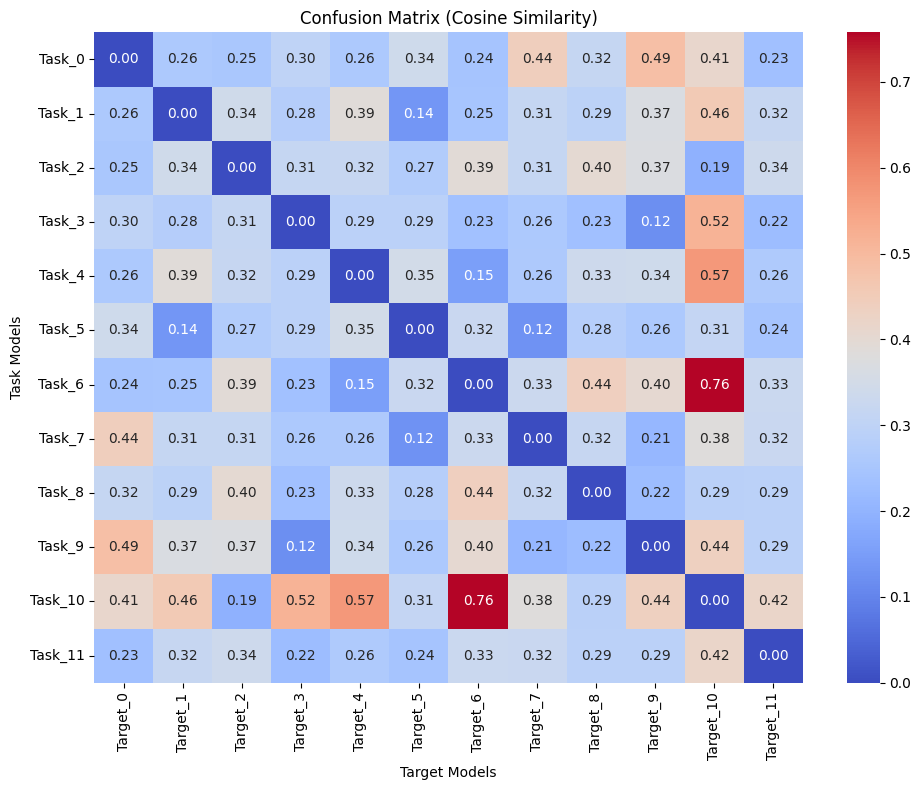

Displaying Confusion Matrix for Euclidean Similarity


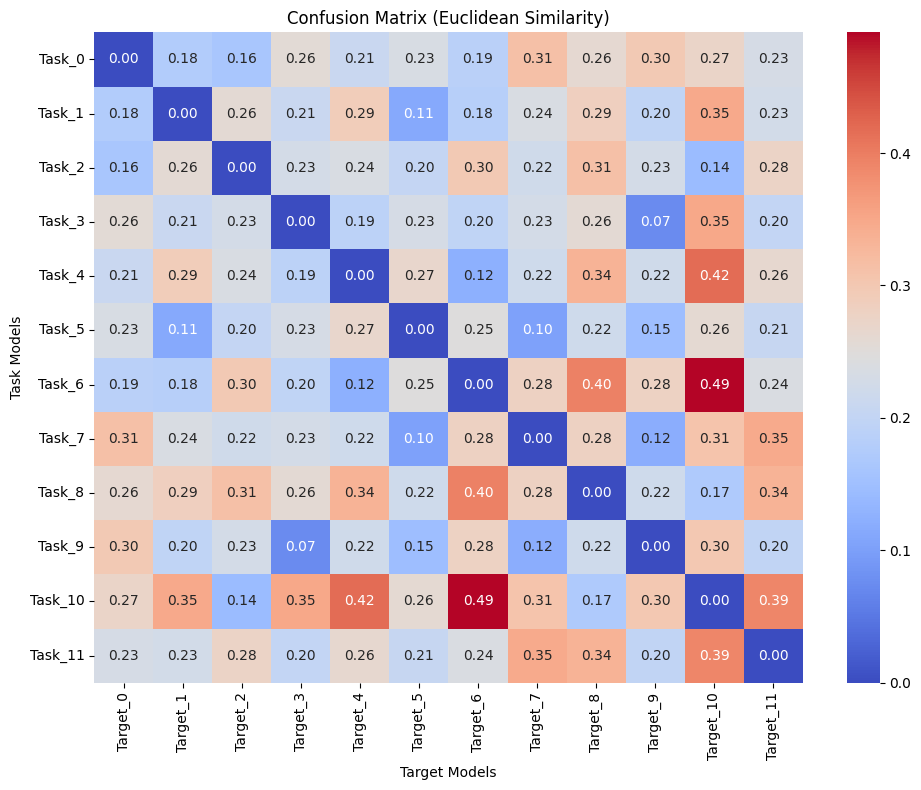

Best task results have been saved:
- /home/youlee/perceiver/perceiver/code/best_cosine_results.txt
- /home/youlee/perceiver/perceiver/code/best_euclidean_results.txt


In [20]:
import seaborn as sns

# Confusion Matrix 생성 (cosine과 euclidean)
num_models = 12
confusion_matrix_cos = np.zeros((num_models, num_models))
confusion_matrix_euc = np.zeros((num_models, num_models))

# ddvcc_list_all와 ddvec_list_all에서 값을 채움
for target_id, task_id, cos_distance in ddvcc_list_all:
    confusion_matrix_cos[task_id, target_id] = cos_distance  # x축과 y축 변경

for target_id, task_id, euc_distance in ddvec_list_all:
    confusion_matrix_euc[task_id, target_id] = euc_distance  # x축과 y축 변경

# DataFrame으로 변환
confusion_df_cos = pd.DataFrame(confusion_matrix_cos, columns=[f"Target_{i}" for i in range(num_models)],
                                index=[f"Task_{i}" for i in range(num_models)])
confusion_df_euc = pd.DataFrame(confusion_matrix_euc, columns=[f"Target_{i}" for i in range(num_models)],
                                index=[f"Task_{i}" for i in range(num_models)])

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(confusion_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.ylabel("Task Models")
    plt.xlabel("Target Models")
    plt.tight_layout()
    plt.show()

# Confusion Matrix 시각화
print("Displaying Confusion Matrix for Cosine Similarity")
plot_confusion_matrix(confusion_df_cos, "Confusion Matrix (Cosine Similarity)")

print("Displaying Confusion Matrix for Euclidean Similarity")
plot_confusion_matrix(confusion_df_euc, "Confusion Matrix (Euclidean Similarity)")

# Best Cosine 및 Euclidean Backbone 결과를 DataFrame으로 정리 및 모달리티 추가
def add_modality_info(df):
    df["Task_Modality"] = df["Task_ID"].apply(lambda x: "Text" if x < 6 else "Image")
    df["Target_Modality"] = df["Best_Target_ID"].apply(lambda x: "Text" if x < 6 else "Image")
    return df

best_cos_df = pd.DataFrame(best_cos_list, columns=["Task_ID", "Best_Target_ID", "Best_Cos_Score"])
best_euc_df = pd.DataFrame(best_euc_list, columns=["Task_ID", "Best_Target_ID", "Best_Euc_Score"])

best_cos_df = add_modality_info(best_cos_df)
best_euc_df = add_modality_info(best_euc_df)

# Best Task 결과를 파일로 저장 (TXT 형식)
best_cos_df.to_csv("/home/youlee/perceiver/perceiver/code/best_cosine_results.txt", index=False, sep='\t')
best_euc_df.to_csv("/home/youlee/perceiver/perceiver/code/best_euclidean_results.txt", index=False, sep='\t')

print("Best task results have been saved:")
print("- /home/youlee/perceiver/perceiver/code/best_cosine_results.txt")
print("- /home/youlee/perceiver/perceiver/code/best_euclidean_results.txt")


In [21]:
# 파일 경로
cosine_file = "/home/youlee/perceiver/perceiver/code/best_cosine_results.txt"
euclidean_file = "/home/youlee/perceiver/perceiver/code/best_euclidean_results.txt"

# 데이터 로드
best_cos_df = pd.read_csv(cosine_file, sep='\t')
best_euc_df = pd.read_csv(euclidean_file, sep='\t')

# 표로 출력
print("Best Cosine Results")
print(best_cos_df.to_string(index=False))

print("\nBest Euclidean Results")
print(best_euc_df.to_string(index=False))


Best Cosine Results
 Task_ID  Best_Target_ID  Best_Cos_Score Task_Modality Target_Modality
       0               9        0.486685          Text           Image
       1              10        0.457265          Text           Image
       2               8        0.399910          Text           Image
       3              10        0.517965          Text           Image
       4              10        0.569769          Text           Image
       5               4        0.346476          Text            Text
       6              10        0.757795         Image           Image
       7               0        0.442760         Image            Text
       8               6        0.440394         Image           Image
       9               0        0.486685         Image            Text
      10               6        0.757795         Image           Image
      11              10        0.418529         Image           Image

Best Euclidean Results
 Task_ID  Best_Target_ID  Best_Eu

## Approach 2: latent vector로 유사도 검증